## Importing the necessary libraries

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
import string
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer

Using TensorFlow backend.


## Reading in the corpus

In [2]:
# Read csv file into pandas DataFrame
reviews = pd.read_csv("./train_labelled.csv", encoding = 'unicode_escape')

# Examine first 5 lines of reviews
reviews.head()

,Restaurant,Review,Label,Stars,Date
0,Happy Tummy,"Fresh ingredients, friendly peeps and so much ...",1,5,2016-04-06T00:00:00
1,Yan kee Noodle House,The plus point is that the price remains the s...,1,4,2018-12-28T00:00:00
2,Clinton Street Baking Company & Restaurant,Same for more?I ordered what I thought was the...,1,2,2018-03-03T00:00:00
3,Brawn & Brains Coffee,I don't get why it can't just be full service....,1,3,2019-12-17T00:00:00
4,No. 18 Zion Road Char Kway Teow,I stood in line patiently and got a large plat...,1,3,2016-11-21T00:00:00


In [3]:
# Examine last 5 lines of reviews
reviews.tail()

,Restaurant,Review,Label,Stars,Date
3454,Momma Kong's Crab Shack,They had a not so great experience with sotong...,5,3,2015-05-23T00:00:00
3455,Spago By Wolfgang Puck,It'll take you up to the 50 something floor wh...,5,4,2018-01-10T00:00:00
3456,Swee Choon Tim Sum,Tips: Bring cash cause they don't accept credi...,5,5,2019-10-19T00:00:00
3457,Sakae Teppanyaki,The only reason why I visited this store in th...,5,5,2012-08-17T00:00:00
3458,Ki-sho,Ki sho sources for a variety of different spec...,5,5,2019-06-24T00:00:00


In [4]:
# Check for any null rows
reviews.isnull().any()

Restaurant    False
Review        False
Label         False
Stars         False
Date          False
dtype: bool

In [5]:
# Print the number of rows and columns
reviews.shape

(3459, 5)

## Data cleaning

In [6]:
# Build vocabulary of words and their respective counts
corpus = []

for line in reviews['Review']:
    line = line.replace('\n', ' ').replace('\t', ' ').lower() # remove next line, tabs and convert to lower casing
    line = re.sub('[^a-z]', ' ', line) # remove punctuations and numbers
    tokens = line.split(' ')
    tokens = [token for token in tokens if len(token) > 0]
    corpus.extend(tokens)

corpus = Counter(corpus)
print('Number of words before cleaning: ', len(corpus))

Number of words before cleaning:  5958


In [7]:
# SymSpell to correct spelling
class SymSpell:
    def __init__(self, max_edit_distance=3, verbose=0):
        self.max_edit_distance = max_edit_distance
        self.verbose = verbose
        # 0: top suggestion
        # 1: all suggestions of smallest edit distance
        # 2: all suggestions <= max_edit_distance (slower, no early termination)

        self.dictionary = {}
        self.longest_word_length = 0

    def best_word(self, s, silent=False):
        try:
            return self.get_suggestions(s, silent)[0]
        except:
            return None
        
    def create_dictionary_entry(self, w):
        '''add word and its derived deletions to dictionary'''
        # check if word is already in dictionary
        # dictionary entries are in the form: (list of suggested corrections,
        # frequency of word in corpus)
        new_real_word_added = False
        if w in self.dictionary:
            # increment count of word in corpus
            self.dictionary[w] = (self.dictionary[w][0], self.dictionary[w][1] + 1)
        else:
            self.dictionary[w] = ([], 1)
            self.longest_word_length = max(self.longest_word_length, len(w))

        if self.dictionary[w][1] == 1:
            # first appearance of word in corpus
            # n.b. word may already be in dictionary as a derived word
            # (deleting character from a real word)
            # but counter of frequency of word in corpus is not incremented
            # in those cases)
            new_real_word_added = True
            deletes = self.get_deletes_list(w)
            for item in deletes:
                if item in self.dictionary:
                    # add (correct) word to delete's suggested correction list
                    self.dictionary[item][0].append(w)
                else:
                    # note frequency of word in corpus is not incremented
                    self.dictionary[item] = ([w], 0)

        return new_real_word_added
        
    def get_suggestions(self, string, silent=False):
        """return list of suggested corrections for potentially incorrectly
           spelled word"""
        if (len(string) - self.longest_word_length) > self.max_edit_distance:
            if not silent:
                print("no items in dictionary within maximum edit distance")
            return []

        suggest_dict = {}
        min_suggest_len = float('inf')

        queue = [string]
        q_dictionary = {}  # items other than string that we've checked

        while len(queue) > 0:
            q_item = queue[0]  # pop
            queue = queue[1:]

            # early exit
            if ((self.verbose < 2) and (len(suggest_dict) > 0) and
                    ((len(string) - len(q_item)) > min_suggest_len)):
                break

            # process queue item
            if (q_item in self.dictionary) and (q_item not in suggest_dict):
                if self.dictionary[q_item][1] > 0:
                    # word is in dictionary, and is a word from the corpus, and
                    # not already in suggestion list so add to suggestion
                    # dictionary, indexed by the word with value (frequency in
                    # corpus, edit distance)
                    # note q_items that are not the input string are shorter
                    # than input string since only deletes are added (unless
                    # manual dictionary corrections are added)
                    assert len(string) >= len(q_item)
                    suggest_dict[q_item] = (self.dictionary[q_item][1],
                                            len(string) - len(q_item))
                    # early exit
                    if (self.verbose < 2) and (len(string) == len(q_item)):
                        break
                    elif (len(string) - len(q_item)) < min_suggest_len:
                        min_suggest_len = len(string) - len(q_item)

                # the suggested corrections for q_item as stored in
                # dictionary (whether or not q_item itself is a valid word
                # or merely a delete) can be valid corrections
                for sc_item in self.dictionary[q_item][0]:
                    if sc_item not in suggest_dict:

                        # compute edit distance
                        # suggested items should always be longer
                        # (unless manual corrections are added)
                        assert len(sc_item) > len(q_item)

                        # q_items that are not input should be shorter
                        # than original string
                        # (unless manual corrections added)
                        assert len(q_item) <= len(string)

                        if len(q_item) == len(string):
                            assert q_item == string
                            item_dist = len(sc_item) - len(q_item)

                        # item in suggestions list should not be the same as
                        # the string itself
                        assert sc_item != string

                        # calculate edit distance using, for example,
                        # Damerau-Levenshtein distance
                        item_dist = dameraulevenshtein(sc_item, string)

                        # do not add words with greater edit distance if
                        # verbose setting not on
                        if (self.verbose < 2) and (item_dist > min_suggest_len):
                            pass
                        elif item_dist <= self.max_edit_distance:
                            assert sc_item in self.dictionary  # should already be in dictionary if in suggestion list
                            suggest_dict[sc_item] = (self.dictionary[sc_item][1], item_dist)
                            if item_dist < min_suggest_len:
                                min_suggest_len = item_dist

                        # depending on order words are processed, some words
                        # with different edit distances may be entered into
                        # suggestions; trim suggestion dictionary if verbose
                        # setting not on
                        if self.verbose < 2:
                            suggest_dict = {k: v for k, v in suggest_dict.items() if v[1] <= min_suggest_len}

            # now generate deletes (e.g. a substring of string or of a delete)
            # from the queue item
            # as additional items to check -- add to end of queue
            assert len(string) >= len(q_item)

            # do not add words with greater edit distance if verbose setting
            # is not on
            if (self.verbose < 2) and ((len(string) - len(q_item)) > min_suggest_len):
                pass
            elif (len(string) - len(q_item)) < self.max_edit_distance and len(q_item) > 1:
                for c in range(len(q_item)):  # character index
                    word_minus_c = q_item[:c] + q_item[c + 1:]
                    if word_minus_c not in q_dictionary:
                        queue.append(word_minus_c)
                        q_dictionary[word_minus_c] = None  # arbitrary value, just to identify we checked this

        # queue is now empty: convert suggestions in dictionary to
        # list for output
        if not silent and self.verbose != 0:
            print("number of possible corrections: %i" % len(suggest_dict))
            print("  edit distance for deletions: %i" % self.max_edit_distance)

        # output option 1
        # sort results by ascending order of edit distance and descending
        # order of frequency
        #     and return list of suggested word corrections only:
        # return sorted(suggest_dict, key = lambda x:
        #               (suggest_dict[x][1], -suggest_dict[x][0]))

        # output option 2
        # return list of suggestions with (correction,
        #                                  (frequency in corpus, edit distance)):
        as_list = suggest_dict.items()
        # outlist = sorted(as_list, key=lambda (term, (freq, dist)): (dist, -freq))
        outlist = sorted(as_list, key=lambda x: (x[1][1], -x[1][0]))

        if self.verbose == 0:
            return outlist[0]
        else:
            return outlist


In [8]:
# Define function to correct spelling 
def spell_corrector(word_list, words_d) -> str:
    result_list = []
    for word in word_list:
        if word not in words_d:
            suggestion = ss.best_word(word, silent=True)
            if suggestion is not None:
                result_list.append(suggestion)
        else:
            result_list.append(word)
            
    return " ".join(result_list)

In [9]:
# Create SymSpell object
ss = SymSpell(max_edit_distance=2)

In [10]:
# Cleaning the Data
def clean(data):

    # Removing leading and trailing white spaces
    data = str(data).strip()
    
    # Converting all text to lower case
    data = data.lower() 
    
    # Adding space for punctuation
    translator = re.compile('[%s]' % re.escape(string.punctuation))
    translator.sub(' ', data)

    # Removing punctuation
    data = re.sub('[^A-Za-z0-9]+', ' ', data)
    
    # Keeping only english words
    data = re.sub(r'[^\x00-\x7F]+', '', data)
    
    # Keeping printable
    data = re.sub(f'[^{re.escape(string.printable)}]', '', data)

    # Tokenizing data
    tokens = word_tokenize(data)

    # Correcting spelling mistakes
    correct_text = spell_corrector(tokens, corpus)

    return correct_text

# clean text data
reviews["Review_clean"] = reviews["Review"].apply(lambda x: clean(x))
reviews

,Restaurant,Review,Label,Stars,Date,Review_clean
0,Happy Tummy,"Fresh ingredients, friendly peeps and so much ...",1,5,2016-04-06T00:00:00,fresh ingredients friendly peeps and so much c...
1,Yan kee Noodle House,The plus point is that the price remains the s...,1,4,2018-12-28T00:00:00,the plus point is that the price remains the s...
2,Clinton Street Baking Company & Restaurant,Same for more?I ordered what I thought was the...,1,2,2018-03-03T00:00:00,same for more i ordered what i thought was the...
3,Brawn & Brains Coffee,I don't get why it can't just be full service....,1,3,2019-12-17T00:00:00,i don t get why it can t just be full service ...
4,No. 18 Zion Road Char Kway Teow,I stood in line patiently and got a large plat...,1,3,2016-11-21T00:00:00,i stood in line patiently and got a large plat...
...,...,...,...,...,...,...
3454,Momma Kong's Crab Shack,They had a not so great experience with sotong...,5,3,2015-05-23T00:00:00,they had a not so great experience with sotong...
3455,Spago By Wolfgang Puck,It'll take you up to the 50 something floor wh...,5,4,2018-01-10T00:00:00,it ll take you up to the something floor where...
3456,Swee Choon Tim Sum,Tips: Bring cash cause they don't accept credi...,5,5,2019-10-19T00:00:00,tips bring cash cause they don t accept credit...
3457,Sakae Teppanyaki,The only reason why I visited this store in th...,5,5,2012-08-17T00:00:00,the only reason why i visited this store in th...


In [11]:
# Build vocabulary of cleaned text and their respective counts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews.Review_clean)
print("Number of words after cleaning: ", len(tokenizer.word_index))

Number of words after cleaning:  5938


In [12]:
# Write to a clean csv file
reviews.to_csv('train_cleaned.csv')

## Exploratory Data

In [142]:
# Getting an index for each restaurant
restaurant_names = []

for i in reviews['Restaurant']:
    if not i in restaurant_names:
        restaurant_names.append(i)
        
restaurant_dict = dict()

for index, i in enumerate(restaurant_names):
    restaurant_dict[i] = index
    
reviews['enum_restaurant'] = reviews['Restaurant'].apply(lambda x : restaurant_dict[x])

Text(0, 0.5, 'Frequency of Reviews')

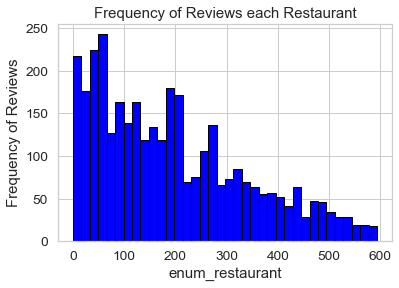

In [143]:
# Frequency of reviews from each restaurant
plt.hist(reviews['enum_restaurant'], color = 'blue', edgecolor = 'black',bins = int(180/5))
plt.title("Frequency of Reviews each Restaurant")
plt.xlabel("enum_restaurant")
plt.ylabel("Frequency of Reviews")

C:\Users\xuehu\.conda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


Text(0, 0.5, 'Frequency of Restaurants')

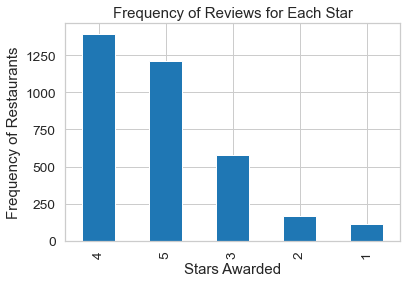

In [144]:
# Frequency of number of stars
reviews['Stars'].value_counts().plot('bar')
plt.title("Frequency of Reviews for Each Star")
plt.xlabel("Stars Awarded")
plt.ylabel("Frequency of Restaurants")

C:\Users\xuehu\.conda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


Text(0, 0.5, 'Frequency of Restaurants')

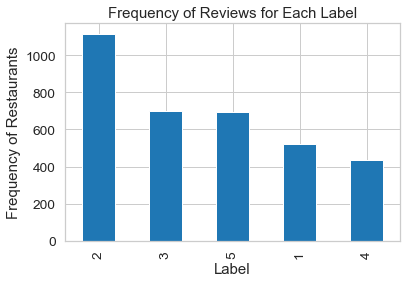

In [145]:
# Frequency of labels
reviews['Label'].value_counts().plot('bar')
plt.title("Frequency of Reviews for Each Label")
plt.xlabel("Label")
plt.ylabel("Frequency of Restaurants")

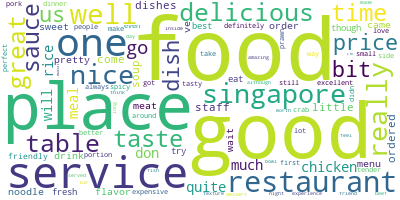

In [146]:
# Creating a WordCloud to analyse the data
long_string = ','.join(list(reviews['Review_clean'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

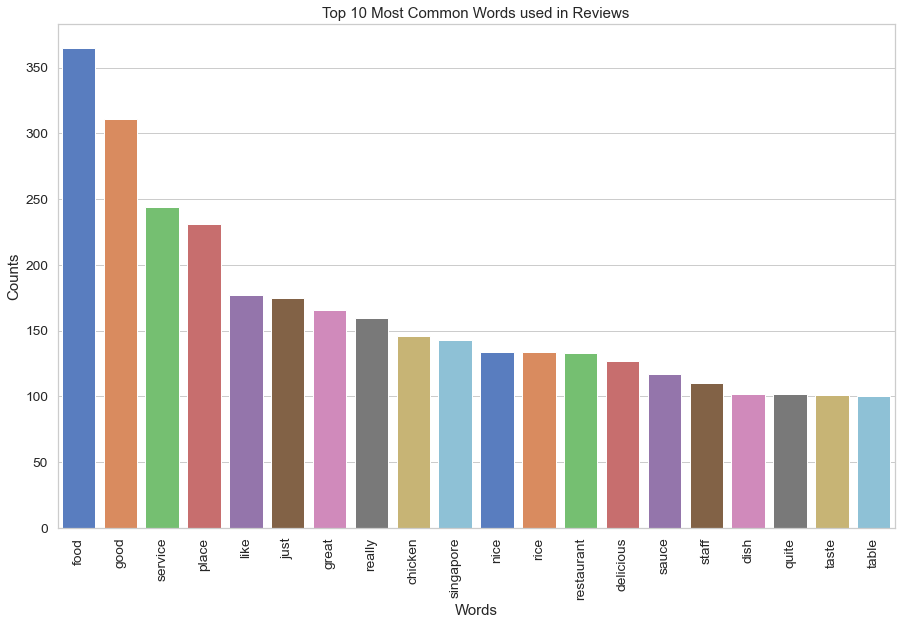

In [147]:
# Getting the top 10 most common words used in reviews
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Top 10 Most Common Words used in Reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='muted')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(reviews['Review_clean'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)